In [1]:
import xarray as xr
import glob
import os
import regex as re
import matplotlib.pyplot as plt
import pandas as pd
from dask.diagnostics import ProgressBar
import dask

In [13]:
rootdir = '/scratch/gpfs/graemem/'
rootdir_merra2 = rootdir+'merra2/'
rootdir_sos = '/scratch/gpfs/graemem/en4/EN.4.2.2_regridded/'
rootdir_wmt = rootdir+'merra2_wmt/'
ppname = '*'
year = '*'
filename = 'MERRA2_*00.tavgM_2d_*_Nx.'+str(year)+'*.nc4'
pathstr = rootdir_merra2+ppname+'/'+filename
paths = glob.glob(pathstr)
paths[0]

'/scratch/gpfs/graemem/merra2/M2TMNXOCN/MERRA2_400.tavgM_2d_ocn_Nx.201112.nc4'

In [14]:
pathsnow=paths

In [15]:
ds = xr.open_mfdataset(pathsnow)

In [16]:
variables = ['EFLUX','EVAP','FRSEAICE','HFLUX','PRECTOT','PRECTOTCORR',
             'EFLUXICE','EFLUXWTR','HFLUXICE','HFLUXWTR','LWGNTICE',
             'LWGNTWTR','PRECSNOOCN','RAINOCN','SWGNTICE','SWGNTWTR',
             'TSKINICE','TSKINWTR']
ds = ds[variables].chunk({'time':120})

In [17]:
ds

<xarray.Dataset>
Dimensions:      (time: 505, lat: 361, lon: 576)
Coordinates:
  * lon          (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * lat          (lat) float64 -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * time         (time) datetime64[ns] 1980-01-01T00:30:00 ... 2022-06-01T00:...
Data variables: (12/18)
    EFLUX        (time, lat, lon) float32 dask.array<chunksize=(120, 361, 576), meta=np.ndarray>
    EVAP         (time, lat, lon) float32 dask.array<chunksize=(120, 361, 576), meta=np.ndarray>
    FRSEAICE     (time, lat, lon) float32 dask.array<chunksize=(120, 361, 576), meta=np.ndarray>
    HFLUX        (time, lat, lon) float32 dask.array<chunksize=(120, 361, 576), meta=np.ndarray>
    PRECTOT      (time, lat, lon) float32 dask.array<chunksize=(120, 361, 576), meta=np.ndarray>
    PRECTOTCORR  (time, lat, lon) float32 dask.array<chunksize=(120, 361, 576), meta=np.ndarray>
    ...           ...
    PRECSNOOCN   (time, lat, lon) float32 dask.array<chunksize=(120, 361, 576), meta=np.ndarray>
    RAINOCN      (time, lat, lon) float32 dask.array<chunksize=(120, 361, 576), meta=np.ndarray>
    SWGNTICE     (time, lat, lon) float32 dask.array<chunksize=(120, 361, 576), meta=np.ndarray>
    SWGNTWTR     (time, lat, lon) float32 dask.array<chunksize=(120, 361, 576), meta=np.ndarray>
    TSKINICE     (time, lat, lon) float32 dask.array<chunksize=(120, 361, 576), meta=np.ndarray>
    TSKINWTR     (time, lat, lon) float32 dask.array<chunksize=(120, 361, 576), meta=np.ndarray>
Attributes: (12/30)
    History:                           Original file generated: Thu May  7 23...
    Filename:                          MERRA2_100.tavgM_2d_flx_Nx.198001.nc4
    Comment:                           GMAO filename: d5124_m2_jan79.tavg1_2d...
    Conventions:                       CF-1
    Institution:                       NASA Global Modeling and Assimilation ...
    References:                        http://gmao.gsfc.nasa.gov
    ...                                ...
    DataResolution:                    0.5 x 0.625
    Source:                            CVS tag: GEOSadas-5_12_4
    Contact:                           http://gmao.gsfc.nasa.gov
    identifier_product_doi:            10.5067/0JRLVL8YV2Y4
    RangeBeginningTime:                00:00:00.000000
    RangeEndingTime:                   23:59:59.000000

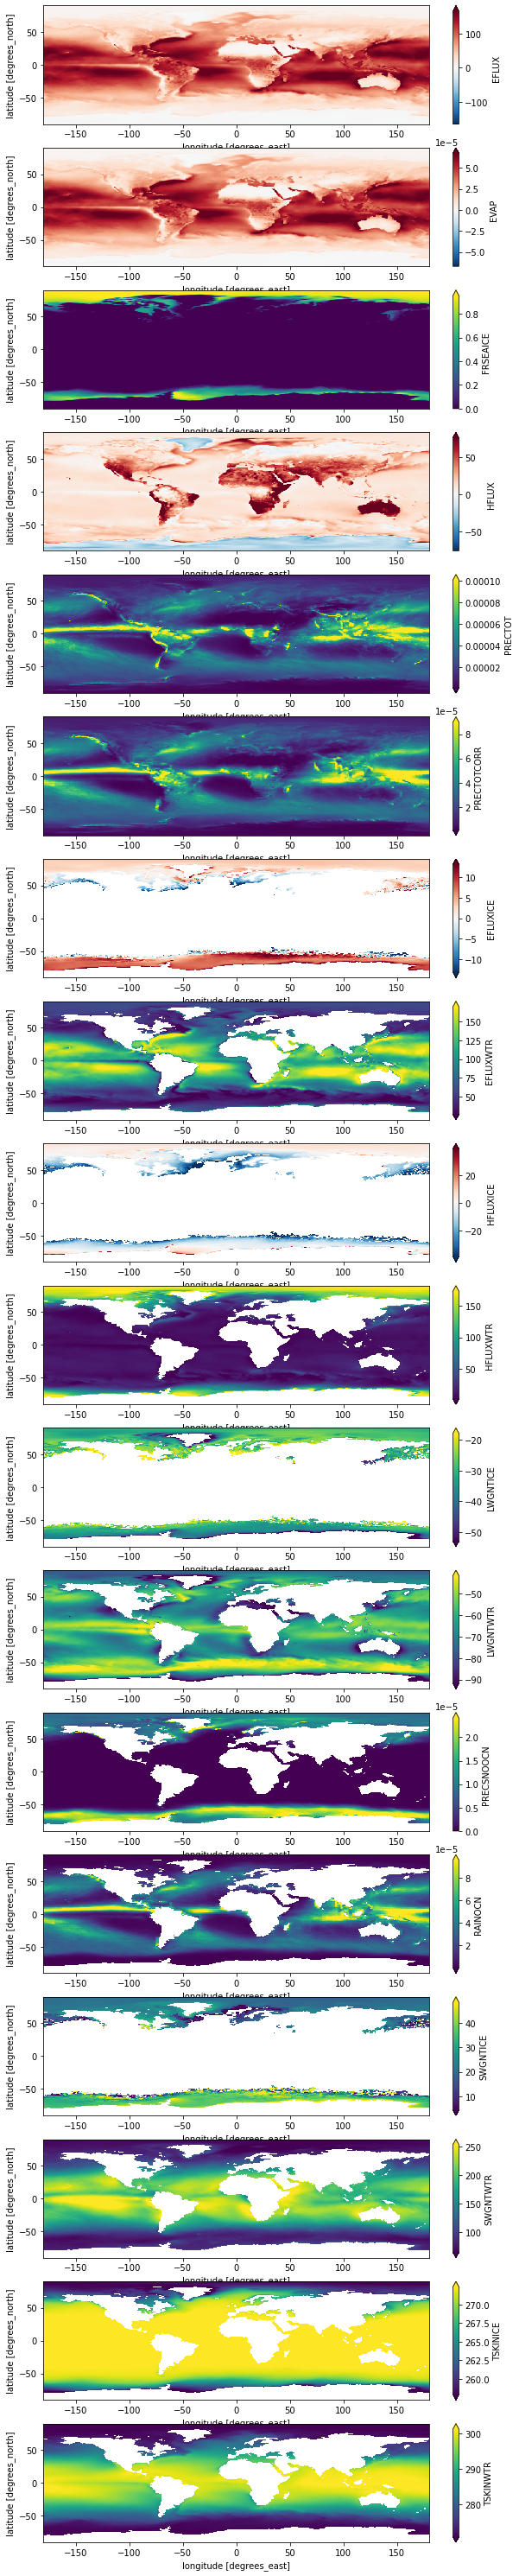

In [18]:
nv = len(ds.data_vars)
fig,axarr = plt.subplots(figsize=(10,3*nv),nrows=nv)
for i,variable in enumerate(ds.data_vars):
    ax = axarr.flat[i]
    da = ds[variable].isel(time=slice(0,24)).mean('time')
    da.plot(ax=ax,robust=True)

In [19]:
ds_wmt = xr.Dataset()
# Calculate terms
ds_wmt['tos'] = ds['TSKINWTR']-273.15
ds_wmt['hfds'] = (ds['SWGNTWTR']+ds['LWGNTWTR']-ds['EFLUXWTR']-ds['HFLUXWTR'])
ds_wmt['wfo'] = (ds['PRECTOTCORR']-ds['EVAP'])

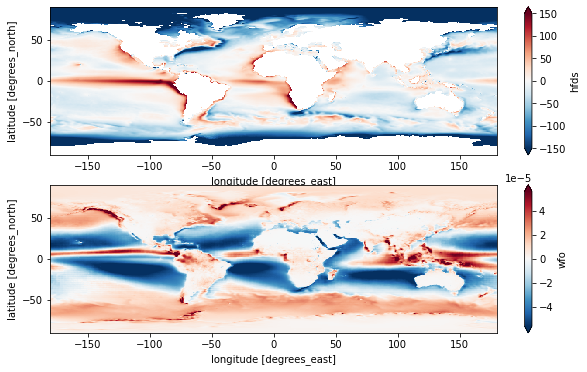

In [20]:
fig,(ax1,ax2) = plt.subplots(figsize=(10,6),nrows=2)
ds_wmt['hfds'].isel(time=slice(-240,-1)).mean('time').plot(ax=ax1,robust=True,vmin=-150,vmax=150,cmap='RdBu_r')
ds_wmt['wfo'].isel(time=slice(-240,-1)).mean('time').plot(ax=ax2,robust=True)

In [21]:
### Get SoS from en4
sos = xr.open_zarr(rootdir_sos+'merra2.zarr')['salinity']
sos_wmt = (sos.
           sel(time=ds['time'],method='nearest',drop=True).
           assign_coords(ds.coords).
           chunk({'time':120}))
ds_wmt['sos'] = sos_wmt

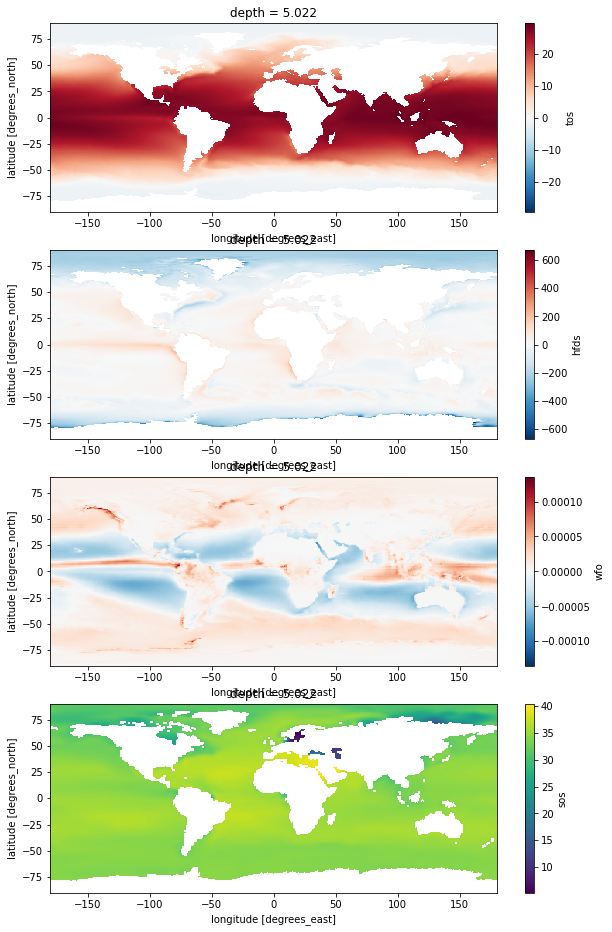

In [22]:
nv = len(ds_wmt.data_vars)
fig,ax = plt.subplots(figsize=(10,4*nv),nrows=nv)
for i,varname in enumerate(ds_wmt.data_vars):
    da = ds_wmt[varname].isel(time=slice(0,120)).mean('time')
    da.plot(ax=ax[i])

In [23]:
with ProgressBar():
    ds_wmt.to_zarr(rootdir_wmt+'merra2.en4.ds.zarr',mode='w')

[########################################] | 100% Completed | 101.19 s
